# **Experiments for paper**: "*Highly Smoothness Zero-Order Methods for Solving Optimization Problems under PL Condition*"

We consider the following optimization problem:
\begin{equation}
  \min_{x \in \mathbb{R}^d} f(x) := \|g(x)\|^2_2,
\end{equation}
where $g(x)=0$ is a system of $p$ nonlinear equations $(p \leq d)$
\begin{equation}
  g(x) = A\sin (x) + B\cos (x) - c,
\end{equation}
$x\in \mathbb{R}^d$ and  $A,B \in \mathbb{R}^{p\times d}$, $c \in \mathbb{R}^p$. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
from scipy.stats import logistic
import time
import random
import json
import string
import math
import pathlib
import matplotlib.pyplot as plt
sigm = logistic.cdf
from sklearn.preprocessing import normalize
from tqdm import tqdm
import numpy.matlib as mt  
from scipy.sparse import csc_matrix
import scipy

In [ ]:
class Expiriments():
  def __init__(self, d, p, Q):
    #------------------------------------------------------------------------------- 
    # d is dimention of x                                       ///---self.dim---///
    # p is number of nonlinear equations                   ///---self.p_non_eq---///
    # self.x_solve is solve the optimization problem 
    # [-Q,Q] is interval of solving the optimization problem
    # self.A_problem, self.B_problem are matrix from statement problem (pxd)
    # self.c_problem is vector from statement problem (px1)
    # x_0 is initial point                                  ///---self.x_start---///
    # gamma is parameter for approximation of the gradient    ///---self.gamma---/// 
    # Batch is batch size from Mini-batch SGD                 ///---self.Batch---/// 
    #------------------------------------------------------------------------------- 
    self.dim = d
    self.p_non_eq = p
    self.Q = Q
    self.x_solve = np.random.uniform(-self.Q,self.Q, size=((self.dim, 1)))
    #print('-------------------------------------------------------------------------------')
    #print('---  x_solve = {}'.format(self.x_solve))
    #print('-------------------------------------------------------------------------------')
    self.A_problem = self.sample_A_B()
    self.B_problem = self.sample_A_B()
    self.c_problem = self.A_problem @ np.sin(self.x_solve) + self.B_problem @ np.cos(self.x_solve)
    self.x_start = np.random.uniform(-self.Q,self.Q, size=((self.dim, 1)))

    #print('-------------------------------------------------------------------------------')
    #print('---  self.c_problem = {}'.format(self.c_problem))
    #print('-------------------------------------------------------------------------------')
    pass

  def Objective_fuction_F(self, x):

    function = self.A_problem @ np.sin(x) + self.B_problem @ np.cos(x) - self.c_problem
    Func_Itog = np.linalg.norm(function)**2
    return Func_Itog

  def sample_A_B(self):

    vec = np.random.uniform(-self.Q,self.Q, size=((self.p_non_eq, self.dim)))#np.random.randn(self.p_non_eq, self.dim)
    vec /= np.linalg.norm(vec)
    return vec

  def sample_spherical(self):

    vec = np.random.randn(self.dim, 1)
    vec /= np.linalg.norm(vec)
    return vec

  def compute_Kernal(self, beta, r):

    if (beta == 1 or beta == 2):
      Kernal = 3*r
    elif (beta == 3 or beta == 4):
      Kernal = ((15*r) / (4)) * (5 - 7 * r**3)
    elif (beta == 5 or beta == 6):
      Kernal = ((195*r) / (64)) * (99 * r**4 - 126 * r**2 + 35)
    
    return Kernal


  def Approximation_of_gradient_our_paper(self, x, beta, gamma):

    r = np.random.uniform(-1,1)
    e = self.sample_spherical()
    Kernal = self.compute_Kernal(beta, r)
    cost_function_1 = self.Objective_fuction_F(x + gamma*r*e)
    cost_function_2 = self.Objective_fuction_F(x - gamma*r*e)
    grad_kernal = ((cost_function_1 - cost_function_2)* self.dim * Kernal * e) / (2 * gamma)
    return grad_kernal

  def Approximation_of_gradient_Stich_improved(self, x, gamma):

    u = self.sample_spherical()
    cost_function_1 = self.Objective_fuction_F(x + gamma*u)
    cost_function_2 = self.Objective_fuction_F(x - gamma*u)
    grad_gaussian_improved = ((cost_function_1 - cost_function_2) * self.dim * u) / (2*gamma)
    return grad_gaussian_improved
  
  def Approximation_of_gradient_Stich(self, x, gamma):

    u = np.random.randn(self.dim, 1)
    cost_function_1 = self.Objective_fuction_F(x + gamma*u)
    cost_function_2 = self.Objective_fuction_F(x)
    grad_gaussian = ((cost_function_1 - cost_function_2) * u) / (gamma)
    return grad_gaussian

  def Batch_gradient(self, x_Paper, beta, gamma, Batch):

    Grad_Paper = 0
    for i in range (0, Batch):
      Grad_Paper += self.Approximation_of_gradient_our_paper(x_Paper, beta, gamma)
    
    Grad_Paper /= Batch
    return Grad_Paper

  def SGD_MBSGD(self, beta, gamma, Iterations, Batch, stepsize):

    x_Paper = np.copy(self.x_start)
    x_Stich = np.copy(self.x_start)
    x_Stich_improved = np.copy(self.x_start)#delete


    Y_graf_Paper = []
    Y_graf_Stich = []
    Y_graf_Stich_improved = []#delete
    X_graf = []


        #for itera in tqdm(range(1, N+1)):

    for itera in tqdm(range(0, Iterations)):

      Y_graf_Paper.append(self.Objective_fuction_F(x_Paper))
      Y_graf_Stich.append(self.Objective_fuction_F(x_Stich))
      Y_graf_Stich_improved.append(self.Objective_fuction_F(x_Stich_improved))#delete
      X_graf.append(itera)

      grad_Paper = self.Batch_gradient(x_Paper, beta, gamma, Batch)
      grad_Stich = self.Approximation_of_gradient_Stich(x_Stich, gamma)
      grad_Stich_improved = self.Approximation_of_gradient_Stich_improved(x_Stich_improved, gamma)#delete

      x_Paper = x_Paper - stepsize * grad_Paper
      x_Stich = x_Stich - stepsize * grad_Stich
      x_Stich_improved = x_Stich_improved - stepsize * grad_Stich_improved#delete

    plt.plot(X_graf, Y_graf_Paper, color='navy', label=f'"Kernel" approximation')
    plt.plot(X_graf, Y_graf_Stich, color='crimson', label=f'"Gaussian" approximation')
    plt.plot(X_graf, Y_graf_Stich_improved, color='g', label=f'$L_2$ approximation')
    plt.semilogy()
    plt.xlabel("Iterations", fontsize='large')
    plt.ylabel("Loss, $ f ( x_k ) - f^* $")
    #plt.semilogx()
    plt.legend()
    plt.show()
    return(X_graf, Y_graf_Paper, Y_graf_Stich, Y_graf_Stich_improved)






##Generating Figure 1

In [ ]:
#Init: d,p,Q
d = 16#1000#256
p = 5#500#64
Q = 100

model = Expiriments(d,p,Q)

100%|██████████| 60000/60000 [00:13<00:00, 4478.87it/s]


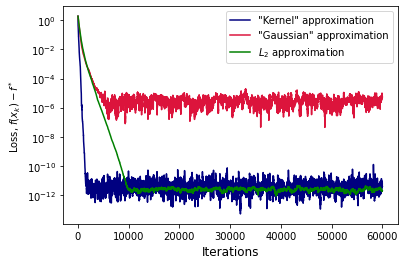

100%|██████████| 60000/60000 [00:45<00:00, 1305.31it/s]


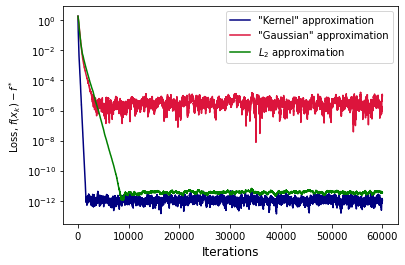

In [ ]:
# beta, gamma, Iterations, Batch, stepsize
beta = 3
gamma = 0.01
Iterations = 60000
Batch = 2
stepsize = 0.01

results1 = model.SGD_MBSGD(beta, gamma, Iterations, 1, stepsize)
results2 = model.SGD_MBSGD(beta, gamma, Iterations, 10, stepsize)

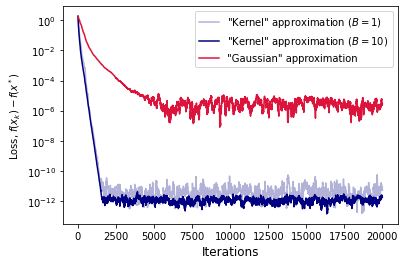

In [ ]:
plt.plot(results1[0][:20000], results1[1][:20000], color='navy', label=f'"Kernel" approximation ($B = 1$)', alpha=0.3)
plt.plot(results2[0][:20000], results2[1][:20000], color='navy', label=f'"Kernel" approximation ($B = 10$)')
plt.plot(results1[0][:20000], results1[2][:20000], color='crimson', label=f'"Gaussian" approximation')
#plt.plot(results[0], results[3], color='g', label=f'$L_2$ approximation')
plt.xlabel("Iterations", fontsize='large')
plt.semilogy()
#plt.semilogx()
plt.ylabel("Loss, $ f(x_k)-f(x^*) $")

plt.legend()
plt.show()

##Generating Figure 2

In [ ]:
#Init: d,p,Q
d = 128#1000#256
p = 16#500#64
Q = 100

model = Expiriments(d,p,Q)

100%|██████████| 60000/60000 [00:22<00:00, 2633.11it/s]


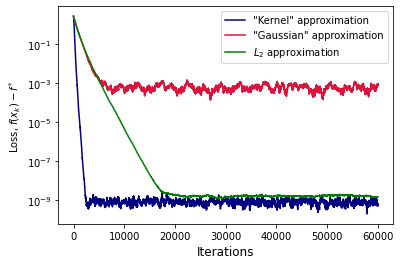

100%|██████████| 60000/60000 [00:22<00:00, 2634.20it/s]


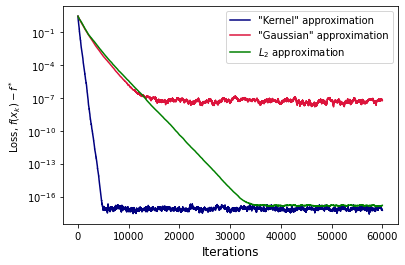

In [ ]:
# beta, gamma, Iterations, Batch, stepsize
beta = 3
gamma = 0.1
Iterations = 60000
Batch = 2
stepsize = 0.01

results_1 = []
results_1.append(model.SGD_MBSGD(beta, 0.1, Iterations, Batch, stepsize))
results_1.append(model.SGD_MBSGD(beta, 0.001, Iterations, Batch, stepsize))

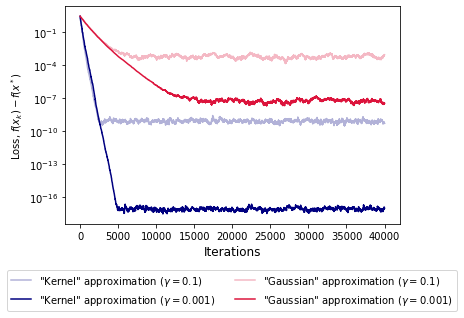

In [ ]:
Gamma =[0.1, 0.001]

X_size = 40000

plt.plot(results_1[0][0][:X_size], results_1[0][1][:X_size], color='navy', label=f'"Kernel" approximation ($\gamma = 0.1$)', alpha=0.3)
plt.plot(results_1[1][0][:X_size], results_1[1][1][:X_size], color='navy', label=f'"Kernel" approximation ($\gamma = 0.001$)')
plt.plot(results_1[0][0][:X_size], results_1[0][2][:X_size], color='crimson', label=f'"Gaussian" approximation ($\gamma = 0.1$)', alpha=0.3)
plt.plot(results_1[1][0][:X_size], results_1[1][2][:X_size], color='crimson', label=f'"Gaussian" approximation ($\gamma = 0.001$)')

#plt.plot(results[0], results[3], color='g', label=f'$L_2$ approximation')
plt.xlabel("Iterations", fontsize='large')
plt.semilogy()
#plt.semilogx()
plt.ylabel("Loss, $ f(x_k)-f(x^*) $")

plt.legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0, ncol=2)
plt.show()


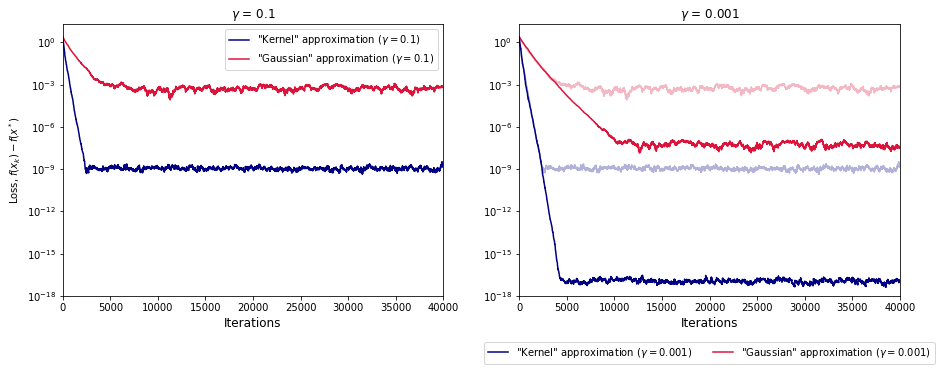

In [ ]:
Gamma =[0.1, 0.001]

X_size = 40000
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x1,x2,y1,y2 = plt.axis()


for i in range(0, 2):
    axs[i].plot(results[i][0][:X_size], results[i][1][:X_size], color='navy', label=f'"Kernel" approximation ($\gamma = {Gamma[i]}$)')
    axs[i].plot(results[i][0][:X_size], results[i][2][:X_size], color='crimson', label=f'"Gaussian" approximation ($\gamma = {Gamma[i]}$)')
    #axs[i].plot(results[i][0][:X_size], results[i][3][:X_size], color='g', label=f'$L_2$ approximation')
    axs[i].set(title = f'$\gamma$ = {Gamma[i]}')
    axs[i].set_xlabel("Iterations", fontsize='large')
    axs[i].semilogy()
    axs[i].legend()
    axs[i].axis((-1,X_size,1e-18, 2e1))
axs[0].set_ylabel("Loss, $ f(x_k)-f(x^*) $")
axs[1].plot(results[0][0][:X_size], results[0][1][:X_size], color='navy', alpha=0.3)
axs[1].plot(results[0][0][:X_size], results[0][2][:X_size], color='crimson', alpha=0.3)

plt.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', borderaxespad=0, ncol=2)
plt.show()

##Generate Figure 3

In [ ]:
#Init: d,p,Q
d = 256#1000#256
p = 32#500#64
Q = 100

model = Expiriments(d,p,Q)

100%|██████████| 60000/60000 [01:45<00:00, 568.00it/s]


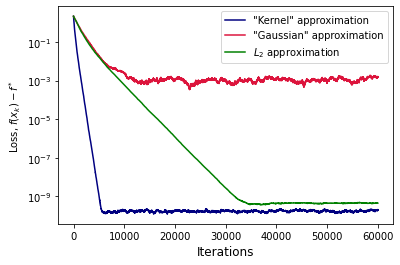

100%|██████████| 60000/60000 [01:44<00:00, 571.97it/s]


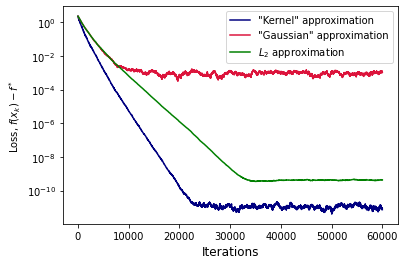

In [ ]:
# beta, gamma, Iterations, Batch, stepsize
beta = 3
gamma = 0.1
Iterations = 60000
Batch = 10
stepsize = 0.01

results_fig_3 = []
results_fig_3.append(model.SGD_MBSGD(3, gamma, Iterations, Batch, stepsize))
results_fig_3.append(model.SGD_MBSGD(5, gamma, Iterations, Batch, stepsize))

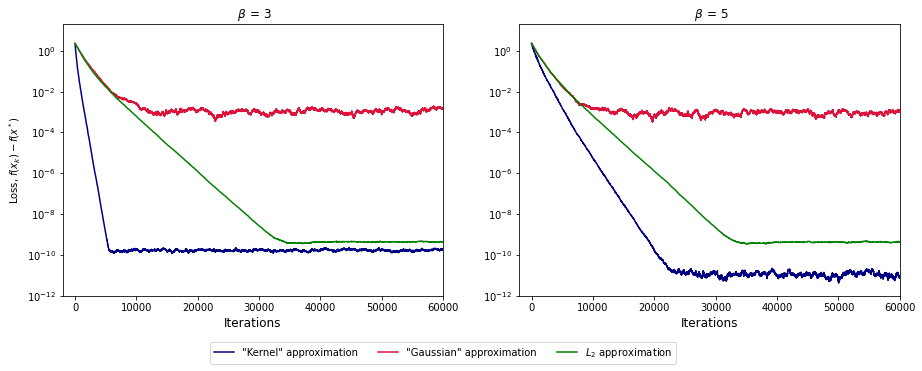

In [ ]:
Beta =[3, 5]

X_size = 60000
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x1,x2,y1,y2 = plt.axis()


for i in range(0, 2):
    axs[i].plot(results_fig_3[i][0][:X_size], results_fig_3[i][1][:X_size], color='navy', label=f'"Kernel" approximation')
    axs[i].plot(results_fig_3[i][0][:X_size], results_fig_3[i][2][:X_size], color='crimson', label=f'"Gaussian" approximation')
    axs[i].plot(results_fig_3[i][0][:X_size], results_fig_3[i][3][:X_size], color='g', label=f'$L_2$ approximation')
    axs[i].set(title = f' $\\beta$ = {Beta[i]}')
    axs[i].set_xlabel("Iterations", fontsize='large')
    axs[i].semilogy()
    #axs[i].legend()
    axs[i].axis((-2000,X_size,1e-12, 2e1))
axs[0].set_ylabel("Loss, $ f(x_k)-f(x^*) $")
#axs[1].plot(results_fig_3[0][0][:X_size], results_fig_3[0][1][:X_size], color='navy', alpha=0.3)
#axs[1].plot(results_fig_3[0][0][:X_size], results_fig_3[0][2][:X_size], color='crimson', alpha=0.3) 
#axs[1].plot(results_fig_3[0][0][:X_size], results_fig_3[0][3][:X_size], color='g', alpha=0.3)

plt.legend(bbox_to_anchor=(-0.2, -0.25), loc='lower center', borderaxespad=0, ncol=3)
plt.show()

##Generating Figure 4

100%|██████████| 85000/85000 [01:21<00:00, 1039.76it/s]


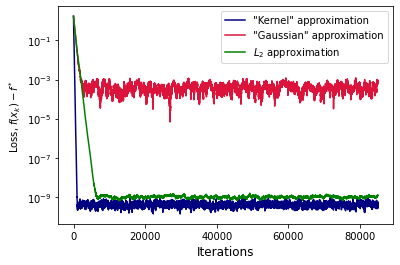

100%|██████████| 85000/85000 [01:23<00:00, 1020.53it/s]


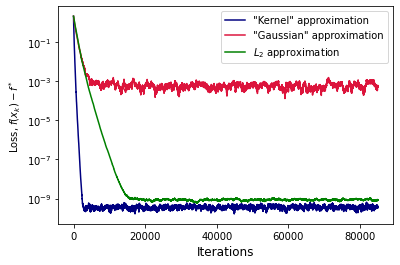

100%|██████████| 85000/85000 [01:24<00:00, 1006.64it/s]


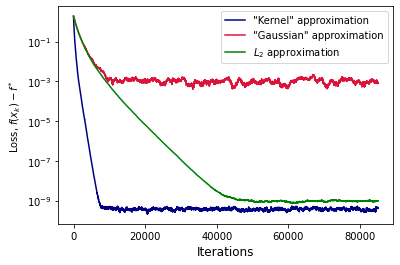

100%|██████████| 85000/85000 [01:46<00:00, 794.91it/s]


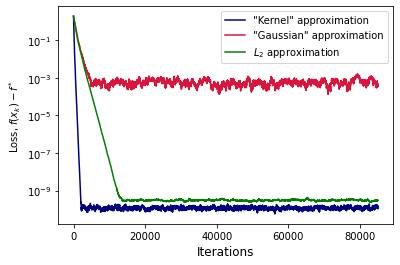

100%|██████████| 85000/85000 [01:52<00:00, 755.35it/s]


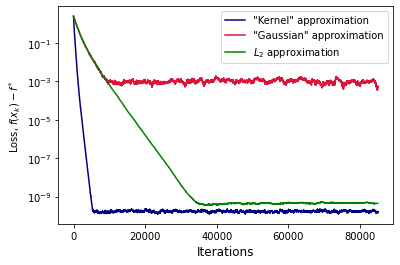

100%|██████████| 85000/85000 [03:03<00:00, 463.03it/s]


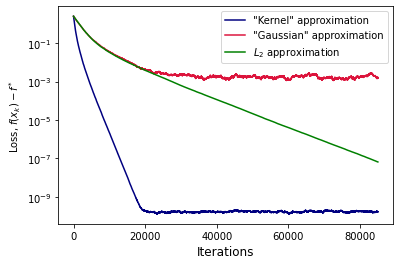

100%|██████████| 85000/85000 [04:10<00:00, 339.24it/s]


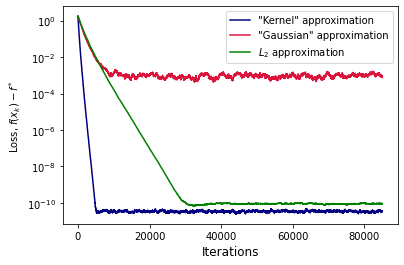

100%|██████████| 85000/85000 [04:31<00:00, 313.45it/s]


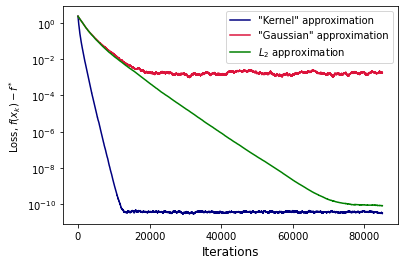

100%|██████████| 85000/85000 [05:06<00:00, 276.95it/s]


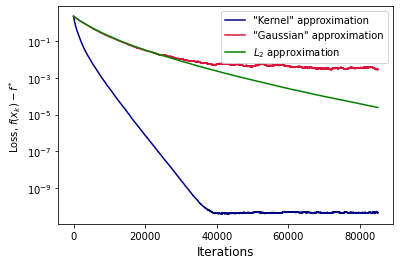

In [ ]:
X_graf_results = []
Y_graf_Kernel_results = []
Y_graf_Gaussian_results = []
Y_graf_L2_results = []

df_graf_Kernel_results = pd.DataFrame({})
df_graf_Gaussian_results = pd.DataFrame({})  
df_graf_L2_results = pd.DataFrame({})  


D = [7, 8, 9]
P = [[3, 4, 5], [4, 5, 6], [5, 6, 7]]

for i in range(0, len(D)):
  for j in range(0, len(P)):
    model = Expiriments(2**D[i], 2**P[i][j], 100)
    # beta, gamma, Iterations, Batch, stepsize
    results = model.SGD_MBSGD(3, 0.1, 85000, 10, 0.01)
    df_graf_Kernel_results[f'dim = {2**D[i]}, p = {2**P[i][j]}'] = results[1] 
    df_graf_Gaussian_results[f'dim = {2**D[i]}, p = {2**P[i][j]}'] = results[2]  
    df_graf_L2_results[f'dim = {2**D[i]}, p = {2**P[i][j]}'] = results[3] 

df_graf_Kernel_results[f'X_graf'] = results[0] 
df_graf_Gaussian_results[f'X_graf'] = results[0]  
df_graf_L2_results[f'X_graf'] = results[0] 

df_graf_Kernel_results.to_csv('df_graf_Kernel_results.csv')
df_graf_Gaussian_results.to_csv('df_graf_Gaussian_results.csv')
df_graf_L2_results.to_csv('df_graf_L2_results.csv')

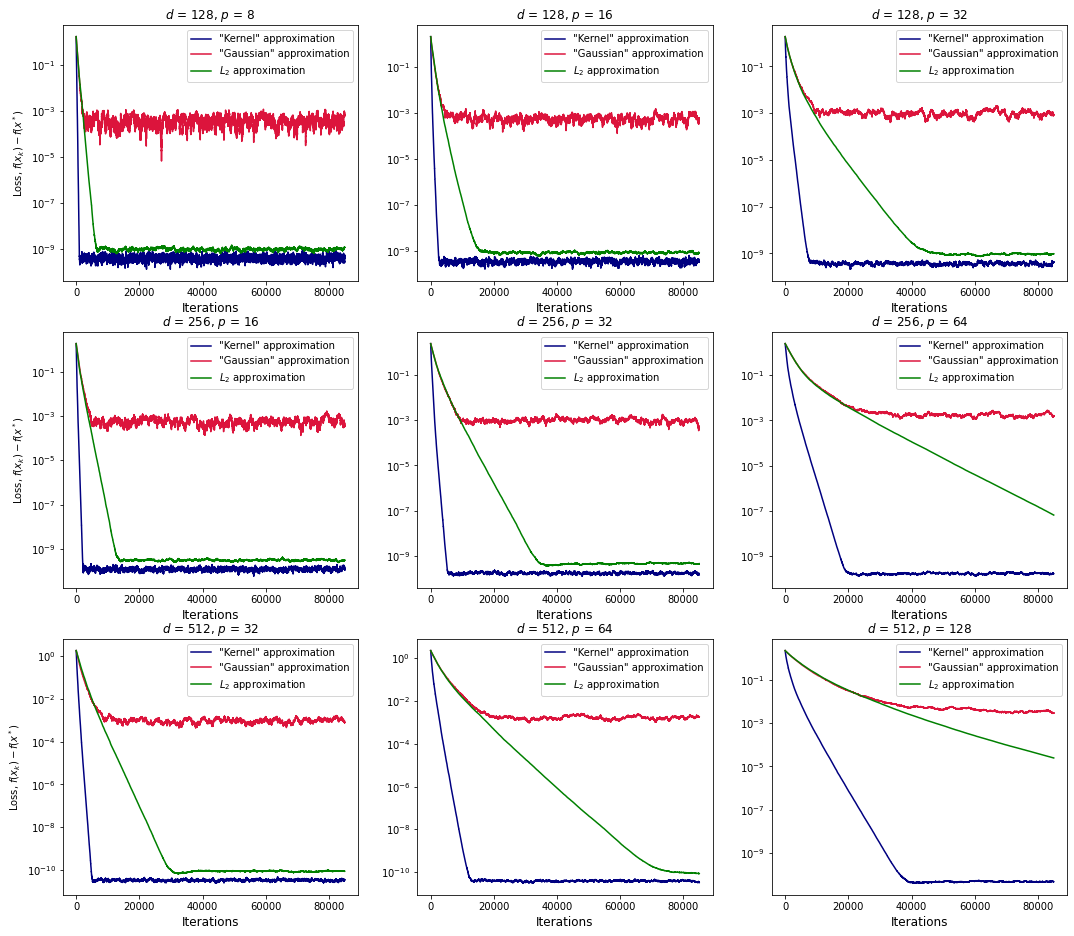

In [ ]:
Kernel_df = pd.read_csv('df_graf_Kernel_results.csv')
Gaussian_df = pd.read_csv('df_graf_Gaussian_results.csv')
L2_df = pd.read_csv('df_graf_L2_results.csv')

D = [7, 8, 9]
P = [[3, 4, 5], [4, 5, 6], [5, 6, 7]]

fig, axs = plt.subplots(3, 3, figsize=(18, 16))

for i in range(0, len(D)):
  for j in range(0, len(P)):
    axs[i, j].plot(Kernel_df[f'X_graf'], Kernel_df[f'dim = {2**D[i]}, p = {2**P[i][j]}'], color='navy', label=f'"Kernel" approximation')
    axs[i, j].plot(Gaussian_df[f'X_graf'], Gaussian_df[f'dim = {2**D[i]}, p = {2**P[i][j]}'], color='crimson', label=f'"Gaussian" approximation')
    axs[i, j].plot(L2_df[f'X_graf'], L2_df[f'dim = {2**D[i]}, p = {2**P[i][j]}'], color='g', label=f'$L_2$ approximation')
    axs[i, j].set(title = f'$d$ = {2**D[i]}, $p$ = {2**P[i][j]}')
    axs[i, j].set_xlabel("Iterations", fontsize='large')
    axs[i ,j].semilogy()
    axs[i, j].legend()
  axs[i, 0].set_ylabel("Loss, $ f(x_k)-f(x^*) $")

plt.legend()
plt.show()

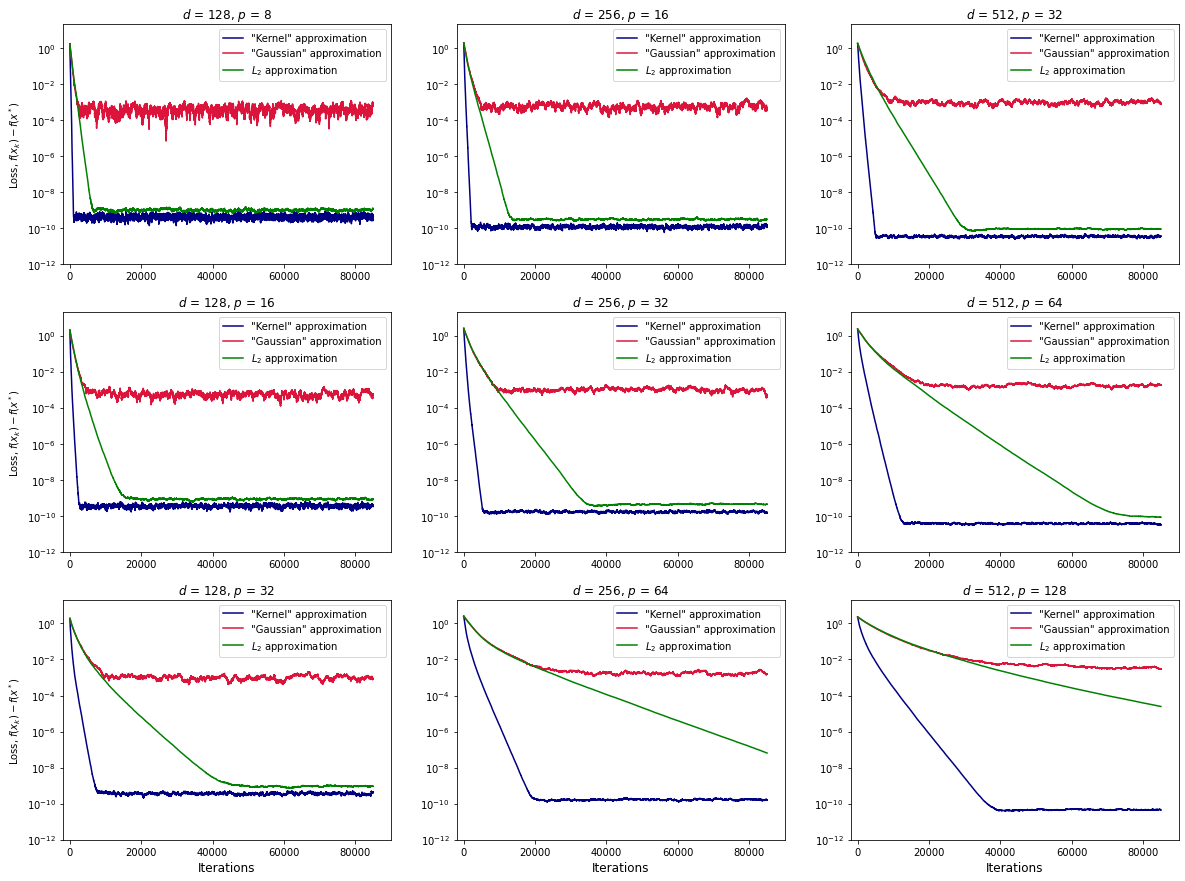

In [ ]:
Kernel_df = pd.read_csv('df_graf_Kernel_results.csv')
Gaussian_df = pd.read_csv('df_graf_Gaussian_results.csv')
L2_df = pd.read_csv('df_graf_L2_results.csv')

D = [7, 8, 9]
P = [[3, 4, 5], [4, 5, 6], [5, 6, 7]]

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
x1,x2,y1,y2 = plt.axis()


for i in range(0, len(D)):
  for j in range(0, len(P)):
    axs[j, i].plot(Kernel_df[f'X_graf'], Kernel_df[f'dim = {2**D[i]}, p = {2**P[i][j]}'], color='navy', label=f'"Kernel" approximation')
    axs[j, i].plot(Gaussian_df[f'X_graf'], Gaussian_df[f'dim = {2**D[i]}, p = {2**P[i][j]}'], color='crimson', label=f'"Gaussian" approximation')
    axs[j, i].plot(L2_df[f'X_graf'], L2_df[f'dim = {2**D[i]}, p = {2**P[i][j]}'], color='g', label=f'$L_2$ approximation')
    axs[j, i].set(title = f'$d$ = {2**D[i]}, $p$ = {2**P[i][j]}')
    axs[j, i].semilogy()
    axs[j, i].legend()
    axs[j, i].axis((-2000,90000,1e-12, 2e1))
    axs[2, j].set_xlabel("Iterations", fontsize='large')
  axs[i, 0].set_ylabel("Loss, $ f(x_k)-f(x^*) $")

plt.legend()
#plt.legend(bbox_to_anchor=(-0.7, -0.3), loc='lower center', borderaxespad=0, ncol=3)
plt.show()

In [ ]:
Kernel_df

,Unnamed: 0,"dim = 64, p = 8","dim = 64, p = 16","dim = 64, p = 32","dim = 256, p = 8","dim = 256, p = 16","dim = 256, p = 32","dim = 1024, p = 8","dim = 1024, p = 16","dim = 1024, p = 32",X_graf
0,0,1.997682e+00,8.620424e-01,2.038388e+00,2.016724e+00,1.545597e+00,1.797431e+00,1.811862e+00,2.233614e+00,9.867662e-01,0
1,1,1.995750e+00,8.401039e-01,1.992945e+00,1.977374e+00,1.511756e+00,1.790318e+00,1.735724e+00,2.214048e+00,9.752104e-01,1
2,2,1.942831e+00,8.146132e-01,1.986614e+00,1.921146e+00,1.486316e+00,1.760466e+00,1.717849e+00,2.207530e+00,9.459596e-01,2
3,3,1.851900e+00,8.135874e-01,1.976714e+00,1.907356e+00,1.476852e+00,1.723443e+00,1.712135e+00,2.177269e+00,9.429246e-01,3
4,4,1.826498e+00,8.109761e-01,1.952136e+00,1.825238e+00,1.449187e+00,1.703123e+00,1.709665e+00,2.130025e+00,9.295398e-01,4
...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,4.050793e-09,1.621031e-09,1.631802e-09,2.157381e-10,1.716443e-10,9.229372e-11,6.855331e-12,1.280180e-11,1.374677e-11,99995
99996,99996,4.089281e-09,1.620712e-09,1.623648e-09,2.212866e-10,1.699475e-10,9.195022e-11,6.765590e-12,1.302869e-11,1.368697e-11,99996
99997,99997,4.062325e-09,1.618384e-09,1.608154e-09,2.207798e-10,1.697844e-10,9.162253e-11,6.808185e-12,1.300659e-11,1.382012e-11,99997
99998,99998,4.047579e-09,1.652964e-09,1.611410e-09,2.189181e-10,1.708146e-10,9.152344e-11,6.949251e-12,1.311016e-11,1.377620e-11,99998


100%|██████████| 600000/600000 [52:48<00:00, 189.35it/s]


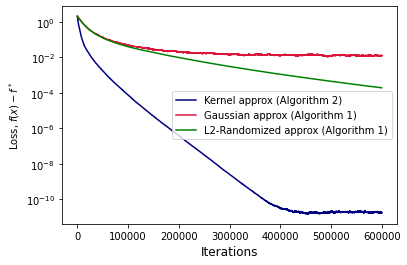

(1.773236743786123e-11,
 0.012520713283996489,
 2.076419290633655,
 2.076419290633655)

In [ ]:
# beta, gamma, Iterations, Batch, stepsize
beta = 3
gamma = 0.1
Iterations = 1000000
Batch = 1
stepsize = 0.01

model.SGD_MBSGD(beta, gamma, Iterations, Batch, stepsize)

100%|██████████| 1000000/1000000 [1:26:00<00:00, 193.79it/s]
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


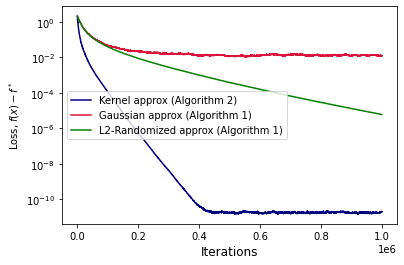

(2.0261207319289912e-11,
 0.012151178334420103,
 2.076419290633655,
 2.076419290633655)

In [ ]:
# beta, gamma, Iterations, Batch, stepsize###d = 1000, p = 500
beta = 3
gamma = 0.1
Iterations = 1000000
Batch = 1
stepsize = 0.01

model.SGD_MBSGD(beta, gamma, Iterations, Batch, stepsize)

100%|██████████| 250000/250000 [06:14<00:00, 668.02it/s]


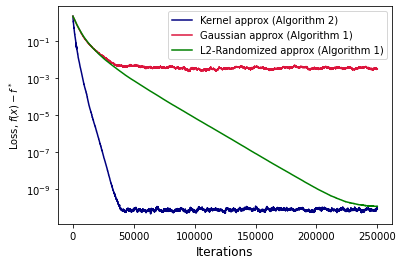

(7.749735285405898e-11,
 0.0030984663957477152,
 2.1624383617878213,
 2.1624383617878213)

In [ ]:
# beta, gamma, Iterations, Batch, stepsize
beta = 3
gamma = 0.1
Iterations = 250000
Batch = 1
stepsize = 0.01

model.SGD_MBSGD(beta, gamma, Iterations, Batch, stepsize)

100%|██████████| 250000/250000 [12:17<00:00, 338.78it/s]


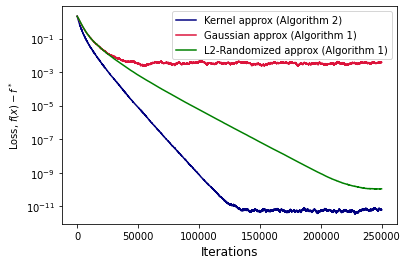

(6.247673914872422e-12,
 0.003915226593583461,
 2.1624383617878213,
 2.1624383617878213)

In [ ]:
# beta, gamma, Iterations, Batch, stepsize
beta = 5
gamma = 0.1
Iterations = 250000
Batch = 5
stepsize = 0.01

model.SGD_MBSGD(beta, gamma, Iterations, Batch, stepsize)